# Information Retrieval and Web Analytics

# FINAL PROJECT

#Astrid Alins, Miquel Bisbe, Cinta Carot


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Necessary imports

In [3]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import re


#### Load data into memory


In [5]:
docs_path = '/content/drive/Shared drives/IRWA/FINAL PROJECT/fashion_products_dataset.json'
with open(docs_path, 'r', encoding='utf-8') as f:
    documents = json.load(f)

print(f"Number of docs: {len(documents)}")

Number of docs: 28080


## 1. Part 1: Text Processing and Exploratory Data Analysis



### 1.1
Preprocessing of the documents
- Removing stop words
- Tokenization
- Removing punctuation marks
- Stemming
- Bonus point

In [6]:
# Initialize the stemmer and stop words set (from nltk)
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))
#Function to clean line by line:
def clean_line(text):
    # Normalize text:
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)# remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip() # remove extra spaces

    # Tokenize
    tokens = text.split()

    # Remove stop words and stemming
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words and len(w) > 2]

    return tokens

In [7]:
for doc in documents:
    doc['title_tokens'] = clean_line(doc.get('title', ''))
    doc['desc_tokens'] = clean_line(doc.get('description', ''))

###1.2
Take into account that for future queries, the final output must return (when present) the following information for each of the selected documents: pid, title, description, brand, category, sub_category, product_details, seller, out_of_stock, selling_price, discount, actual_price, average_rating, url


In [8]:
def preprocess_document(doc):
    """
    doc és un diccionari amb tots els camps del producte
    """
    # Camps textuals
    for field in ["title", "description"]:
        if field in doc and isinstance(doc[field], str):
            doc[field] = clean_line(doc[field])

    # Els altres camps es mantenen com estan
    # (només assegura que existeixin)

    return {
        "pid": doc.get("pid"),
        "title": doc.get("title"),
        "description": doc.get("description"),
        "brand": doc.get("brand"),
        "category": doc.get("category"),
        "sub_category": doc.get("sub_category"),
        "product_details": doc.get("product_details"),
        "seller": doc.get("seller"),
        "out_of_stock": doc.get("out_of_stock"),
        "selling_price": doc.get("selling_price"),
        "discount": doc.get("discount"),
        "actual_price": doc.get("actual_price"),
        "average_rating": doc.get("average_rating"),
        "url": doc.get("url")
    }


In [9]:
# Processar una mostra petita per veure resultats
preprocessed_docs = [preprocess_document(doc) for doc in documents[:5]]

for d in preprocessed_docs:
    print(json.dumps(d, indent=2))


{
  "pid": "TKPFCZ9EA7H5FYZH",
  "title": [
    "solid",
    "women",
    "multicolor",
    "track",
    "pant"
  ],
  "description": [
    "yorker",
    "trackpant",
    "made",
    "rich",
    "comb",
    "cotton",
    "give",
    "rich",
    "look",
    "design",
    "comfort",
    "skin",
    "friendli",
    "fabric",
    "itch",
    "free",
    "waistband",
    "great",
    "year",
    "round",
    "use",
    "proudli",
    "made",
    "india"
  ],
  "brand": "York",
  "category": "Clothing and Accessories",
  "sub_category": "Bottomwear",
  "product_details": [
    {
      "Style Code": "1005COMBO2"
    },
    {
      "Closure": "Elastic"
    },
    {
      "Pockets": "Side Pockets"
    },
    {
      "Fabric": "Cotton Blend"
    },
    {
      "Pattern": "Solid"
    },
    {
      "Color": "Multicolor"
    }
  ],
  "seller": "Shyam Enterprises",
  "out_of_stock": false,
  "selling_price": "921",
  "discount": "69% off",
  "actual_price": "2,999",
  "average_rating": "3.9",
  "ur

###1.3
Decide how to handle the fields category, sub_category, brand, product_details, and seller during pre-processing. Should they be merged into a single text field, indexed as separate fields in the inverted index or any other alternative? Justify your choice, considering how their distinctiveness may affect retrieval effectiveness. What are pros and cons of each approach?

-  **Merging into a Single Text Field:** Concatenate the values of these fields into the main text content of the document (e.g., add them to the `description` or create a new `all_text` field).
    *   **Pros:**
        *   Simplifies the indexing process, as you only need one inverted index for the entire text.
        *   Allows for keyword searches across all fields simultaneously.
    *   **Cons:**
        *   Loses the distinctiveness of each field. A search for "Nike" would match "Nike" in the brand, but also if it appears in a product detail or description, which might not be the desired result.
        *   Difficult to perform field-specific searches (e.g., "only show me products where the brand is Nike").
        *   Might introduce noise into the index, making it harder to retrieve relevant documents based on specific attributes.

-  **Indexing as Separate Fields (Faceted Search):** Create separate indices or designate specific fields in your index for each of these fields (`category_index`, `brand_index`, etc.). This is often used in conjunction with the main text index.
    *   **Pros:**
        *   Preserves the distinctiveness of each field, allowing for precise field-specific searches (e.g., `brand:"Nike"`).
        *   Enables faceted search, where users can filter results based on categories, brands, sellers, etc., which greatly enhances user experience and retrieval effectiveness in e-commerce.
        *   Reduces noise in the main text index.
    *   **Cons:**
        *   More complex indexing and querying process compared to a single text field.
        *   Requires more storage space for multiple indices.

-  **Alternative: Combining with Textual Analysis (Hybrid Approach):** Index these fields separately for faceted search and field-specific queries, while also potentially including them in the main text field (or a separate "searchable text" field) after some processing. For `product_details`, you might parse the key-value pairs and index both the keys and values, possibly with weighting.
    *   **Pros:**
        *   Leverages the benefits of both approaches: enables faceted search and precise field-specific queries while still allowing general keyword search that can hit terms in these fields.
        *   Provides more flexibility in querying.
    *   **Cons:**
        *   Most complex to implement and manage.
        *   Requires careful consideration of how to weight terms from different fields in the main text index.

We decided to index brand, category, sub_category, and seller as separate fields, since they contain structured and highly distinctive categorical information. In contrast, product_details will be merged with the main textual fields (title and description), as it provides descriptive terms that are useful for keyword-based retrieval.

This hybrid approach allows better control over field weighting and improves retrieval effectiveness by combining precise filtering (on categorical fields) with richer semantic matching (on textual content). The main drawback is a slightly higher implementation complexity, but the gain in ranking accuracy and interpretability justifies this choice.


###1.4
Consider the fields out_of_stock, selling_price, discount, actual_price, and average_rating. Decide how these should be handled during pre-processing to use in further search. Should they be indexed as textual terms?

Indexing these fields as textual terms would generally not be the most effective approach. This is because:

*   **Numerical/Boolean Nature**: These fields are primarily numerical (selling_price, discount, actual_price, average_rating) or boolean (out_of_stock). Textual indexing is designed for free text search, not for numerical comparisons or filtering based on true/false values.
*   **Loss of Structure and Meaning**: Treating these as text would lose their inherent structure and meaning. You wouldn't be able to easily perform range queries (e.g., products under $50), sort by price, or filter by availability.
*   **Ineffective for Filtering/Sorting**: Users typically want to filter search results based on price range, availability, or sort by rating. Textual indexing doesn't support these operations efficiently or accurately.


To be handled, these fields should be indexed as their native data types and used for filtering, sorting, and potentially range queries:

*   **`out_of_stock`**: This is a boolean field. It should be indexed as a boolean (True/False). This allows users to easily filter for items that are in stock.
*   **`selling_price`**, **`actual_price`**: These are numerical values. They should be converted to a numerical data type (e.g., float or integer) and indexed as such. This enables:
    *   **Range Queries**: Finding products within a specific price range (e.g., $10 - $50).
    *   **Sorting**: Sorting results by price (lowest to highest or highest to lowest).
    *  **Filtering**: Filtering by maximum or minimum price.
Note: You might need to clean the price strings (remove currency symbols, commas) before converting them to numbers.
*   **`discount`**: This is likely a percentage string (e.g., "69% off"). You could extract the numerical percentage and index it as a number to enable sorting by discount amount or filtering for products with a minimum discount.
*   **`average_rating`**: This is a numerical value (often a float). It should be indexed as a number to allow:
    *   **Filtering**: Showing products above a certain rating (e.g., 4.0 and above).
    *   **Sorting**: Sorting results by average rating (highest to lowest).

In summary, these fields are best handled as structured data (boolean or numerical) for effective filtering, sorting, and range queries, rather than being indexed as unstructured text. This aligns with how users typically interact with these types of attributes on e-commerce websites.

# PART 2: Exploratory Data Analysis

In [24]:
# =========================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from itertools import chain

# Convert documents to DataFrame
df = pd.DataFrame(documents)

# -------------------------------
# Data cleaning helper functions
# -------------------------------
def to_float(x):
    """Convert string with symbols or empty to float, if possible."""
    if pd.isna(x):
        return np.nan
    x = re.sub(r'[^0-9.]', '', str(x))
    return float(x) if x else np.nan

def to_discount(x):
    """Extract numeric percentage from discount string."""
    if pd.isna(x):
        return np.nan
    x = re.sub(r'[^0-9.]', '', str(x))
    return float(x) if x else np.nan

# -------------------------------
# Convert fields to numeric types
# -------------------------------
df["selling_price"] = df["selling_price"].apply(to_float)
df["actual_price"] = df["actual_price"].apply(to_float)
df["discount"] = df["discount"].apply(to_discount)
df["average_rating"] = pd.to_numeric(df["average_rating"], errors='coerce')
df["out_of_stock"] = df["out_of_stock"].astype(bool)

# -------------------------------
# Add text statistics
# -------------------------------
df["title_len"] = df["title_tokens"].apply(len)
df["desc_len"] = df["desc_tokens"].apply(len)

df[["selling_price", "actual_price", "discount", "average_rating"]].describe()


,selling_price,actual_price,discount,average_rating
count,28078.000000,27303.000000,27225.000000,25819.000000
mean,705.635088,1455.528110,50.256896,3.627724
std,549.681489,939.977456,16.887287,0.663429
min,99.000000,150.000000,1.000000,1.000000
25%,390.000000,849.000000,40.000000,3.200000
50%,545.000000,1199.000000,53.000000,3.800000
75%,820.000000,1799.000000,63.000000,4.100000
max,7999.000000,12999.000000,87.000000,5.000000


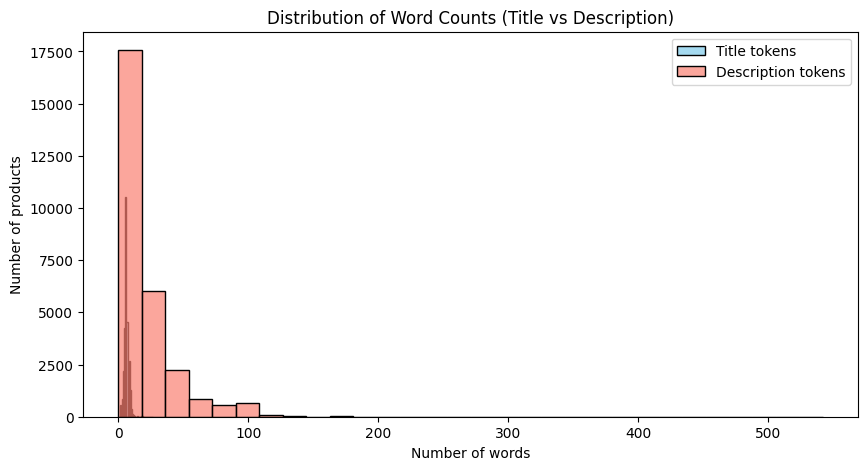

Total unique words in dataset: 4536
Average unique words per description: 15.30


/tmp/ipython-input-4096135227.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rated, x="average_rating", y="title", palette="viridis")


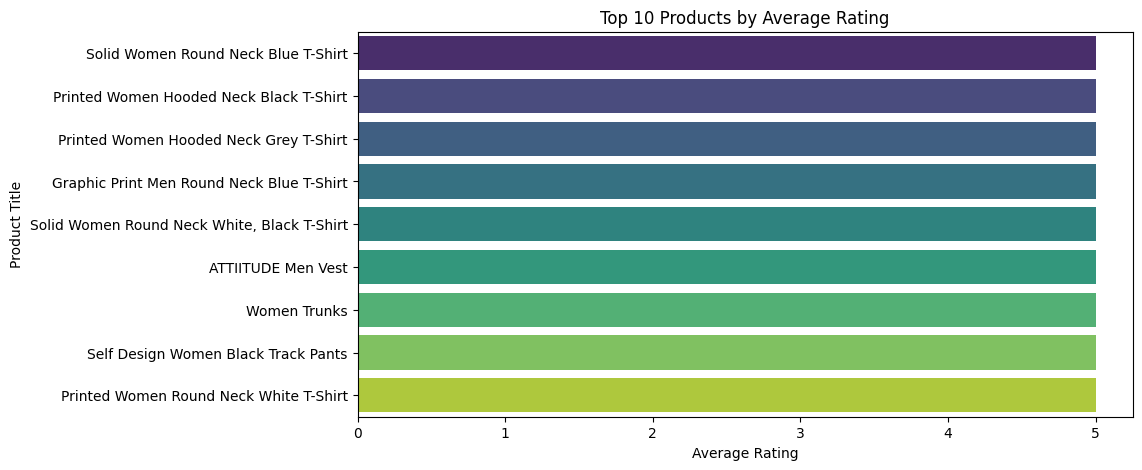

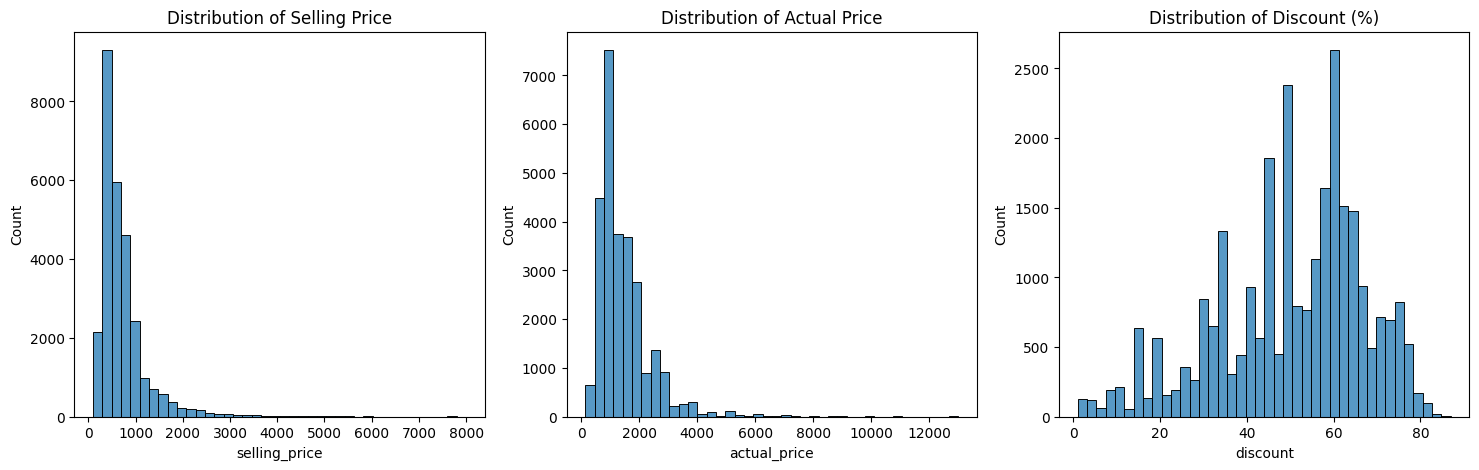

/tmp/ipython-input-4096135227.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, ax=axes[0], palette="Blues_d")
/tmp/ipython-input-4096135227.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sellers.values, y=top_sellers.index, ax=axes[1], palette="Greens_d")


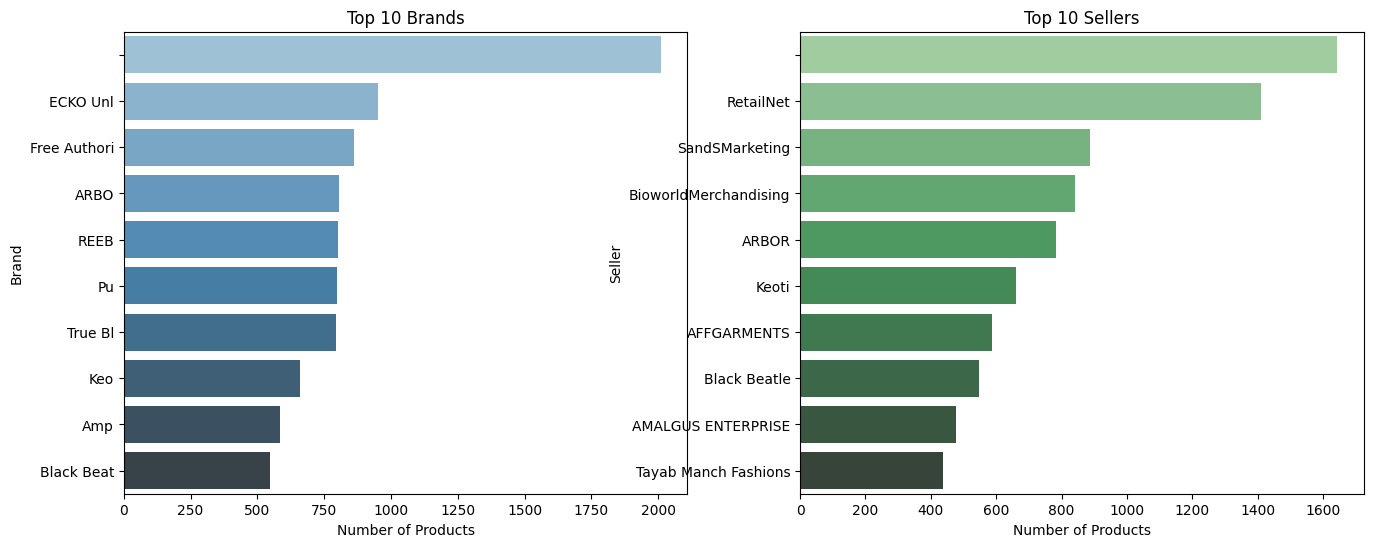

/tmp/ipython-input-4096135227.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=out_stock_counts.index.map({True: 'Out of Stock', False: 'Available'}),


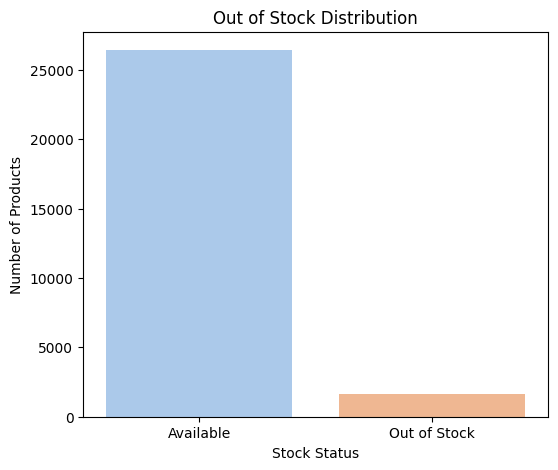

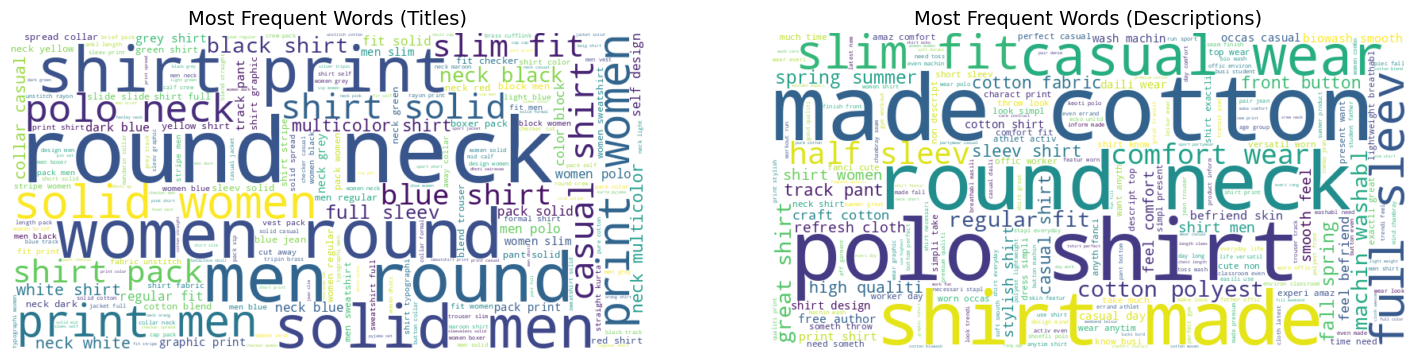

8.94% of products mention a color.


In [25]:

# -------------------------------
# 1. Word count distributions
# -------------------------------
plt.figure(figsize=(10,5))
sns.histplot(df["title_len"], bins=30, color='skyblue', label='Title tokens')
sns.histplot(df["desc_len"], bins=30, color='salmon', label='Description tokens', alpha=0.7)
plt.legend()
plt.title("Distribution of Word Counts (Title vs Description)")
plt.xlabel("Number of words")
plt.ylabel("Number of products")
plt.show()

# -------------------------------
# 2. Vocabulary statistics
# -------------------------------
all_words = list(chain.from_iterable(df["title_tokens"])) + list(chain.from_iterable(df["desc_tokens"]))
vocab = set(all_words)
print(f"Total unique words in dataset: {len(vocab)}")

df["unique_words"] = df["desc_tokens"].apply(lambda x: len(set(x)))
print(f"Average unique words per description: {df['unique_words'].mean():.2f}")

# -------------------------------
# 3. Top-rated products
# -------------------------------
top_rated = df.sort_values(by="average_rating", ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(data=top_rated, x="average_rating", y="title", palette="viridis")
plt.title("Top 10 Products by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Product Title")
plt.show()

# -------------------------------
# 4. Price and discount distributions
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(df["selling_price"], bins=40, ax=axes[0])
axes[0].set_title("Distribution of Selling Price")
sns.histplot(df["actual_price"], bins=40, ax=axes[1])
axes[1].set_title("Distribution of Actual Price")
sns.histplot(df["discount"], bins=40, ax=axes[2])
axes[2].set_title("Distribution of Discount (%)")
plt.show()

# -------------------------------
# 5. Top brands and sellers
# -------------------------------
top_brands = df["brand"].value_counts().head(10)
top_sellers = df["seller"].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(x=top_brands.values, y=top_brands.index, ax=axes[0], palette="Blues_d")
axes[0].set_title("Top 10 Brands")
axes[0].set_xlabel("Number of Products")
axes[0].set_ylabel("Brand")

sns.barplot(x=top_sellers.values, y=top_sellers.index, ax=axes[1], palette="Greens_d")
axes[1].set_title("Top 10 Sellers")
axes[1].set_xlabel("Number of Products")
axes[1].set_ylabel("Seller")
plt.show()

# -------------------------------
# 6. Out of stock distribution
# -------------------------------
out_stock_counts = df["out_of_stock"].value_counts()
plt.figure(figsize=(6,5))
sns.barplot(x=out_stock_counts.index.map({True: 'Out of Stock', False: 'Available'}),
            y=out_stock_counts.values, palette="pastel")
plt.title("Out of Stock Distribution")
plt.xlabel("Stock Status")
plt.ylabel("Number of Products")
plt.show()

# -------------------------------
# 7. Word clouds
# -------------------------------
title_text = ' '.join([' '.join(t) for t in df["title_tokens"]])
desc_text = ' '.join([' '.join(t) for t in df["desc_tokens"]])

fig, ax = plt.subplots(1, 2, figsize=(18,8))
wc_title = WordCloud(width=800, height=400, background_color='white').generate(title_text)
wc_desc = WordCloud(width=800, height=400, background_color='white').generate(desc_text)

ax[0].imshow(wc_title, interpolation='bilinear')
ax[0].set_title("Most Frequent Words (Titles)", fontsize=14)
ax[0].axis('off')
ax[1].imshow(wc_desc, interpolation='bilinear')
ax[1].set_title("Most Frequent Words (Descriptions)", fontsize=14)
ax[1].axis('off')
plt.show()

# -------------------------------
# 8. Optional: Detect colors mentioned
# -------------------------------
color_words = ["red","blue","green","black","white","grey","brown","pink","yellow","multicolor"]
df["has_color"] = df["desc_tokens"].apply(lambda tokens: any(c in tokens for c in color_words))
print(f"{df['has_color'].mean()*100:.2f}% of products mention a color.")
